<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/early_Etv2_peaks_in_MEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigate the early Etv2 peaks in MEFs
by Wuming Gong



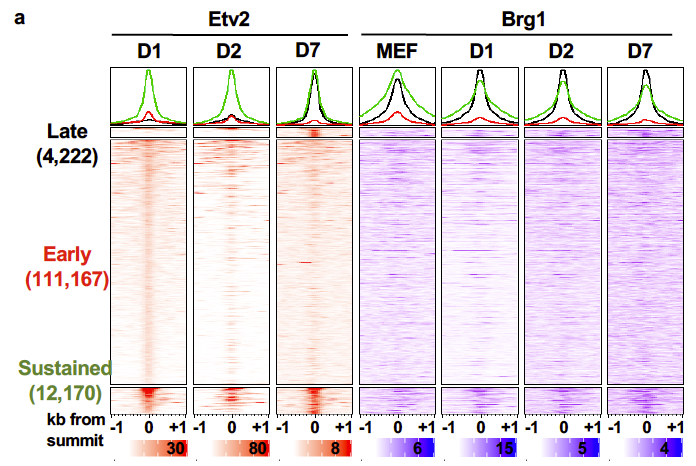

Current analysis showed that there are a large proportion `early` Etv2 peaks that are present in D1 post induction and disappear during the reprogramming.  Most of these early peaks may be due to the random `scanning` events, that are not associated with particular epigenetic environment or motif pattern.  This notebook is to examine the features of early peaks.

In [90]:
start_time0 <- Sys.time()
options(max.print=1000)

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

## Install R packages

In [4]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [171]:
required_packages <- c(
  'devtools', 'BiocManager', 
  'circlize',
  'GenomicRanges', 'rtracklayer', 'EnrichedHeatmap', 'BSgenome.Mmusculus.UCSC.mm10', 'EnrichedHeatmap',
  'gsl', 'DirichletMultinomial', 'motifmatchr', 'chromVAR'
)

In [172]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [9]:
library(devtools)

Loading required package: usethis



### Install R packages that are not available on CRAN or Bioc

In [10]:
if (!require('chromVARmotifs'))
  devtools::install_github("GreenleafLab/chromVARmotifs")

Loading required package: chromVARmotifs

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘chromVARmotifs’”



ps (1.4.0 -> 1.5.0) [CRAN]


Installing 1 packages: ps

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmpds6QvB/remotes40678633c/GreenleafLab-chromVARmotifs-38bed55/DESCRIPTION’
─  preparing ‘chromVARmotifs’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘chromVARmotifs_0.2.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [160]:
if (!require('ComplexHeatmap'))
  devtools::install_github("jokergoo/ComplexHeatmap")

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




## Load R packages

In [173]:
library(GenomicRanges)
library(dplyr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(chromVARmotifs)
library(SummarizedExperiment)
library(ggplot2)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(circlize) # colorRamp2

circlize version 0.4.11
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




## Read a combined Etv2 ChIP-seq peak set

In [14]:
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- all_etv2_peaks_url %>%
  url() %>%
  gzcon() %>%
  readRDS()
gr
colnames(gr$group)

GRanges object with 162010 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3263790-3263989      * | /panfs/roc/scratch/g..   8.36521
       [3]     chr1   3344682-3344881      * | /panfs/roc/scratch/g..   9.73217
       [4]     chr1   3460640-3460839      * | /panfs/roc/scratch/g..   3.92081
       [5]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       ...      ...               ...    ... .                    ...       ...
  [162006]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [162007]     chrY 90836259-90836458      * | /panfs/roc/scratch/g..   8.27339
  [162008]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [162009]     chrY 90842563-90842762      * | /panfs/roc/scra

[1] "MEF_Dox_d1_Etv2" "MEF_Dox_d2_Etv2" "MEF_Dox_d7_Etv2" "EB_Dox_3h_Etv2" 
[5] "EB_Dox_12h_Etv2"

## Download related `pileup` and `fold enrichment` bigwig files

`rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'. We need to download the bigwig files first.

In [13]:
bw_files <- c(
	'MEF_Dox_D1_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
	'MEF_Dox_D2_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
	'MEF_Dox_D7_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
	'MEF_NoDox_Brg1' 										= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
	'MEF_Dox_D1_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
	'MEF_Dox_D2_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
	'MEF_Dox_D7_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_NoDox_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw',
  'MEF_Dox_D1_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_H3K27ac_FE.bw',
  'MEF_Dox_D2_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_H3K27ac_FE.bw',
  'MEF_Dox_D7_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw'
#	'MNase'                             = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/MNase_treat_pileup.bw',
#	'H3'                                = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3_treat_pileup.bw',
#	'H3K9me3'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K9me3_treat_pileup.bw',
#	'H3K27me3'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K27me3_treat_pileup.bw',
#	'H3K36me3'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K36me3_treat_pileup.bw',
#	'H3K9ac'                            = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K9ac_treat_pileup.bw',
#	'H3K79me2'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K79me2_treat_pileup.bw',
#	'H3K4me2'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K4me2_treat_pileup.bw',
#	'H3K4me1'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K4me1_treat_pileup.bw',
#	'Hdac1'                             = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/Hdac1_treat_pileup.bw',
#	'H3.3'                              = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3.3_treat_pileup.bw',
#	'P300'                              = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/P300_treat_pileup.bw',
#	'EB_Dox_3h_Etv2' 					= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Etv2_FE.bw',
#	'EB_Dox_12h_Etv2' 					= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_Etv2_FE.bw',
#	'EB_Dox_3h_Brg1' =  'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Brg1_FE.bw',
#	'EB_Dox_12h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_Brg1_FE.bw',
#	'EB_NoDox_3h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_3h_Brg1_FE.bw',
#	'EB_NoDox_12h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_Brg1_FE.bw',
#	'EB_Dox_3h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_H3K27ac_FE.bw',
#	'EB_Dox_12h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw',
#	'EB_NoDox_3h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_3h_H3K27ac_FE.bw',
#	'EB_NoDox_12h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw'
)

In [19]:
for (i in 1:length(local_bw_files)){
  sprintf('wget -x -c -nH %s', bw_files[i]) %>% system()
}
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)
message(sprintf('all local_bw_files exist: %s', all(file.exists(local_bw_files))))

all local_bw_files exist: TRUE



## Split the Etv2 MEF D1 peaks into three groups
1. on at D1 and off at D7 (early)
2. off at D1 and on at D7 (late)
3. on at both D1 and D7 (sustained)

In [21]:
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
message(sprintf('number of early peaks: %d\n', sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & !peaks$group[, 'MEF_Dox_d7_Etv2'])))
message(sprintf('number of late peaks: %d\n', sum(!peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])))
message(sprintf('number of sustained peaks: %d\n', sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])))

number of early peaks: 111167


number of late peaks: 4222


number of sustained peaks: 12170




## Load motifs

In [23]:
data('homer_pwms')

In [27]:
homer_pwms['Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)']

PWMatrixList of length 1
names(1): Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)

## Find motif binding sites

In [139]:
params <- expand.grid(
  cutoff = c(5e-2, 5e-3, 5e-4, 5e-5, 5e-6, 5e-7),
  width = c(25L, 50L, 75L, 100L)
)

In [140]:
B <- do.call('cbind', lapply(1:nrow(params), function(i){ 
  motif_ix <- matchMotifs(
    homer_pwms['Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)'], 
    resize(peaks, width = params[i, 'width'], fix = 'center'), 
    genome = BSgenome.Mmusculus.UCSC.mm10,
    p.cutoff = params[i, 'cutoff']
  )
  assays(motif_ix)$motifMatches[, 1]
}))

In [141]:
d <- do.call('rbind', lapply(1:ncol(B), function(i){
  cbind(
    rbind(
      data.frame(
        n = sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & !peaks$group[, 'MEF_Dox_d7_Etv2']),
        type = 'early',
        n_Etv2 = sum(B[, i] & peaks$group[, 'MEF_Dox_d1_Etv2'] & !peaks$group[, 'MEF_Dox_d7_Etv2'])
      ),
      data.frame(
        n = sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']),
        type = 'sustained',
        n_Etv2 = sum(B[, i] & peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])
      ),
      data.frame(
        n = sum(!peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']),
        type = 'late',
        n_Etv2 = sum(B[, i] & !peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])
      )
    ),
    params[i, ]
  )
}))

Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been dis

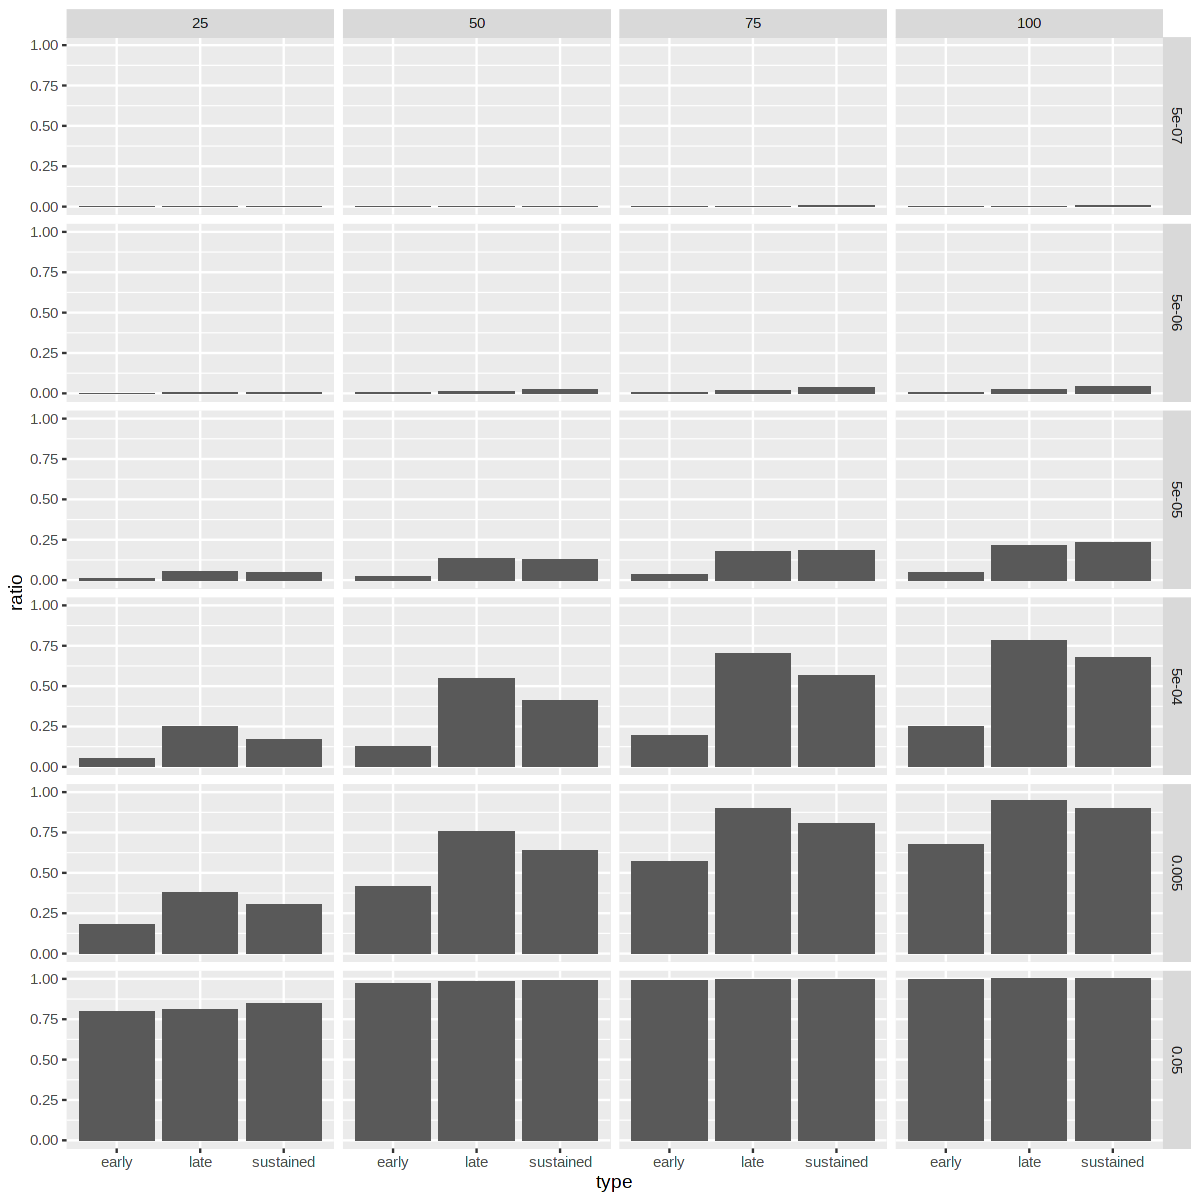

In [142]:
options(repr.plot.width = 10, repr.plot.height = 10)
d %>% 
  mutate(ratio = n_Etv2 / n) %>%
  ggplot(aes(x = type, y = ratio)) +
    geom_bar(stat="identity") +
    facet_grid(cutoff ~ width)


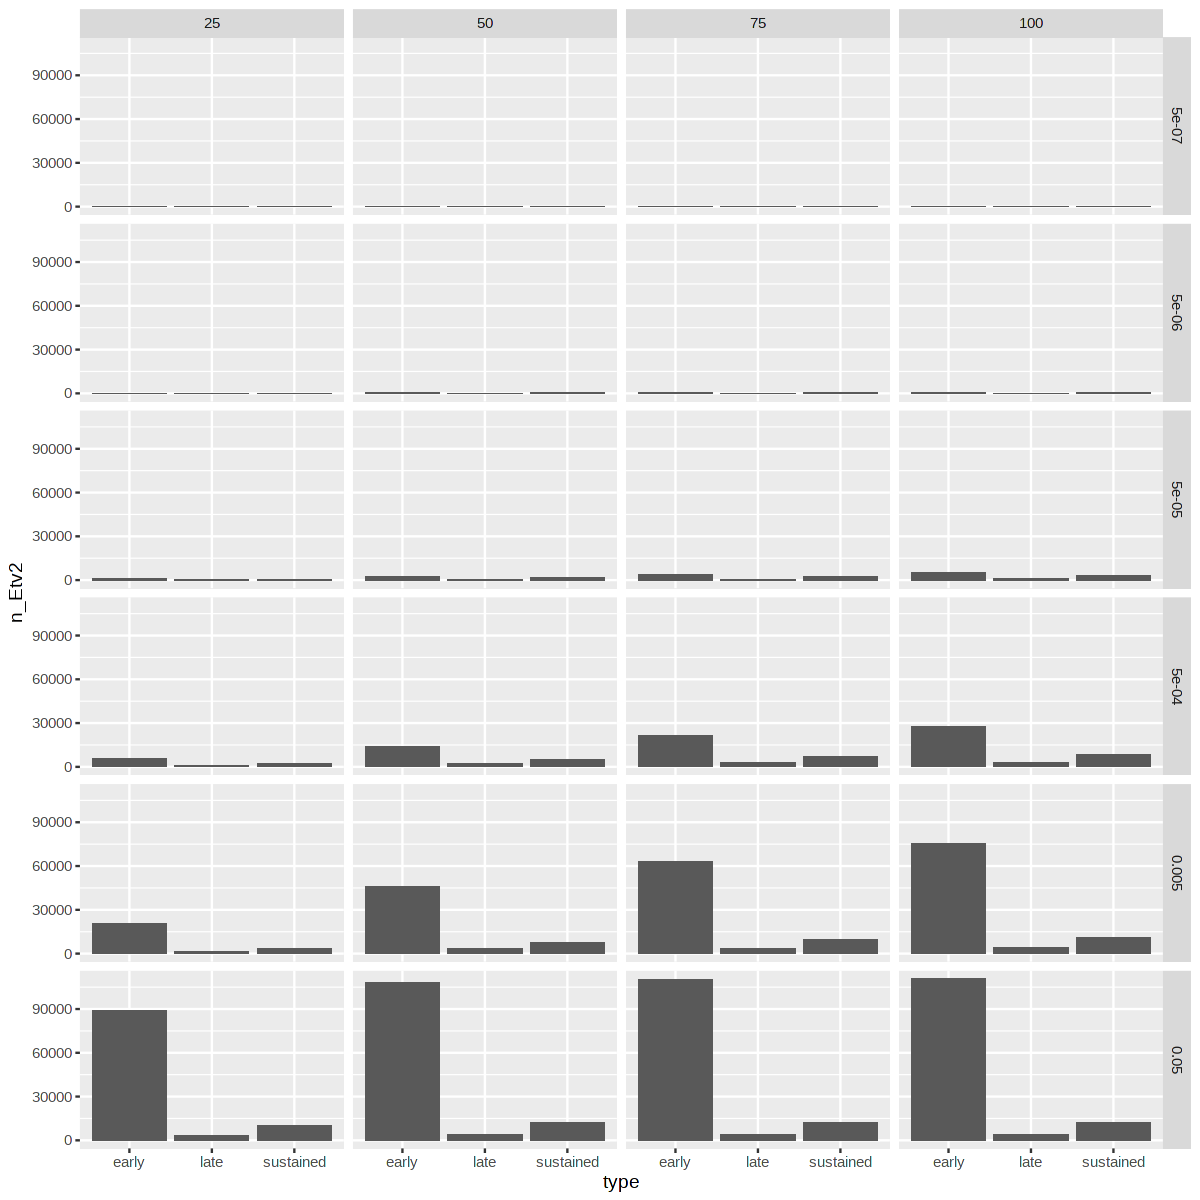

In [143]:
options(repr.plot.width = 10, repr.plot.height = 10)
d %>% 
  ggplot(aes(x = type, y = n_Etv2)) +
    geom_bar(stat="identity") +
    facet_grid(cutoff ~ width)


This analysis support the hypothesis that the `early` Etv2 peaks has relatively less `Etv2` binding motifs.  We will use the `width=50` and `p cutoff=5e-4` for the following analysis.

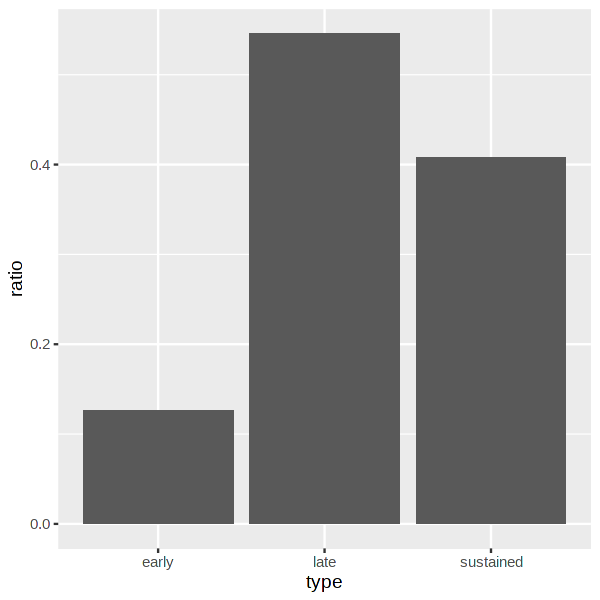

In [144]:
options(repr.plot.width = 5, repr.plot.height = 5)
d %>% 
  filter(width == 50 & cutoff == 5e-4) %>%
  mutate(ratio = n_Etv2 / n) %>%
  ggplot(aes(x = type, y = ratio)) +
    geom_bar(stat="identity")

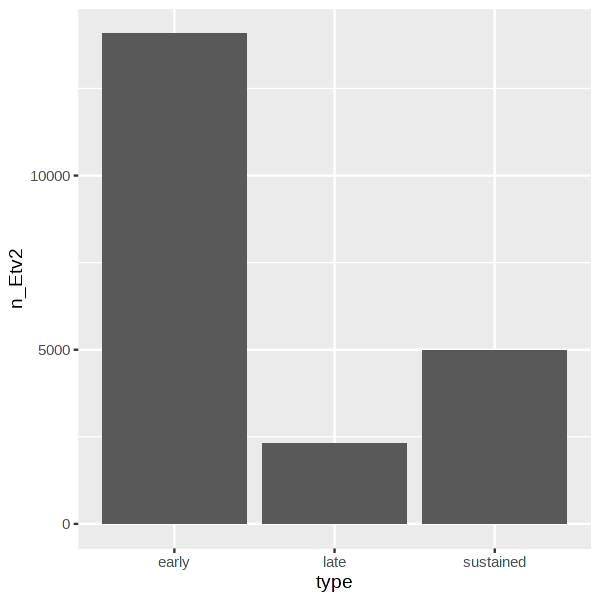

In [145]:
options(repr.plot.width = 5, repr.plot.height = 5)
d %>% 
  filter(width == 50 & cutoff == 5e-4) %>%
  ggplot(aes(x = type, y = n_Etv2)) +
    geom_bar(stat="identity")

## Check the Brg1 and H3K27ac density of Etv2 binding sites with or without canonical Etv2 motifs in MEF reprogramming

In [146]:
gs <- c(
  'MEF_NoDox_Brg1',								
	'MEF_Dox_D1_Brg1', 				
	'MEF_Dox_D2_Brg1', 				
	'MEF_Dox_D7_Brg1', 
  'MEF_NoDox_H3K27ac', 
  'MEF_Dox_D1_H3K27ac',
  'MEF_Dox_D2_H3K27ac',
  'MEF_Dox_D7_H3K27ac'
)

In [147]:
X <- do.call('cbind', lapply(gs, function(g){
  cvg <- rtracklayer::import.bw(local_bw_files[g], which = peaks, as = 'RleList')   # returned as a GRanges object
  cvg[peaks] %>% mean()
}))

In [148]:
has_motif <- B[, which(params$width == 50 & params$cutoff == 5e-4)]

In [149]:
d <- do.call('rbind', lapply(1:length(gs), function(i){
  data.frame(has_motif = has_motif, type = gs[i], value = X[, i], 
    group = ifelse(
      peaks$group[, 'MEF_Dox_d1_Etv2'] & !peaks$group[, 'MEF_Dox_d7_Etv2'], 
      'early', 
      ifelse(
        peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'], 
        'sustained', 
        'late'
      )
    )
  )
}))

`summarise()` regrouping output by 'has_motif', 'type' (override with `.groups` argument)



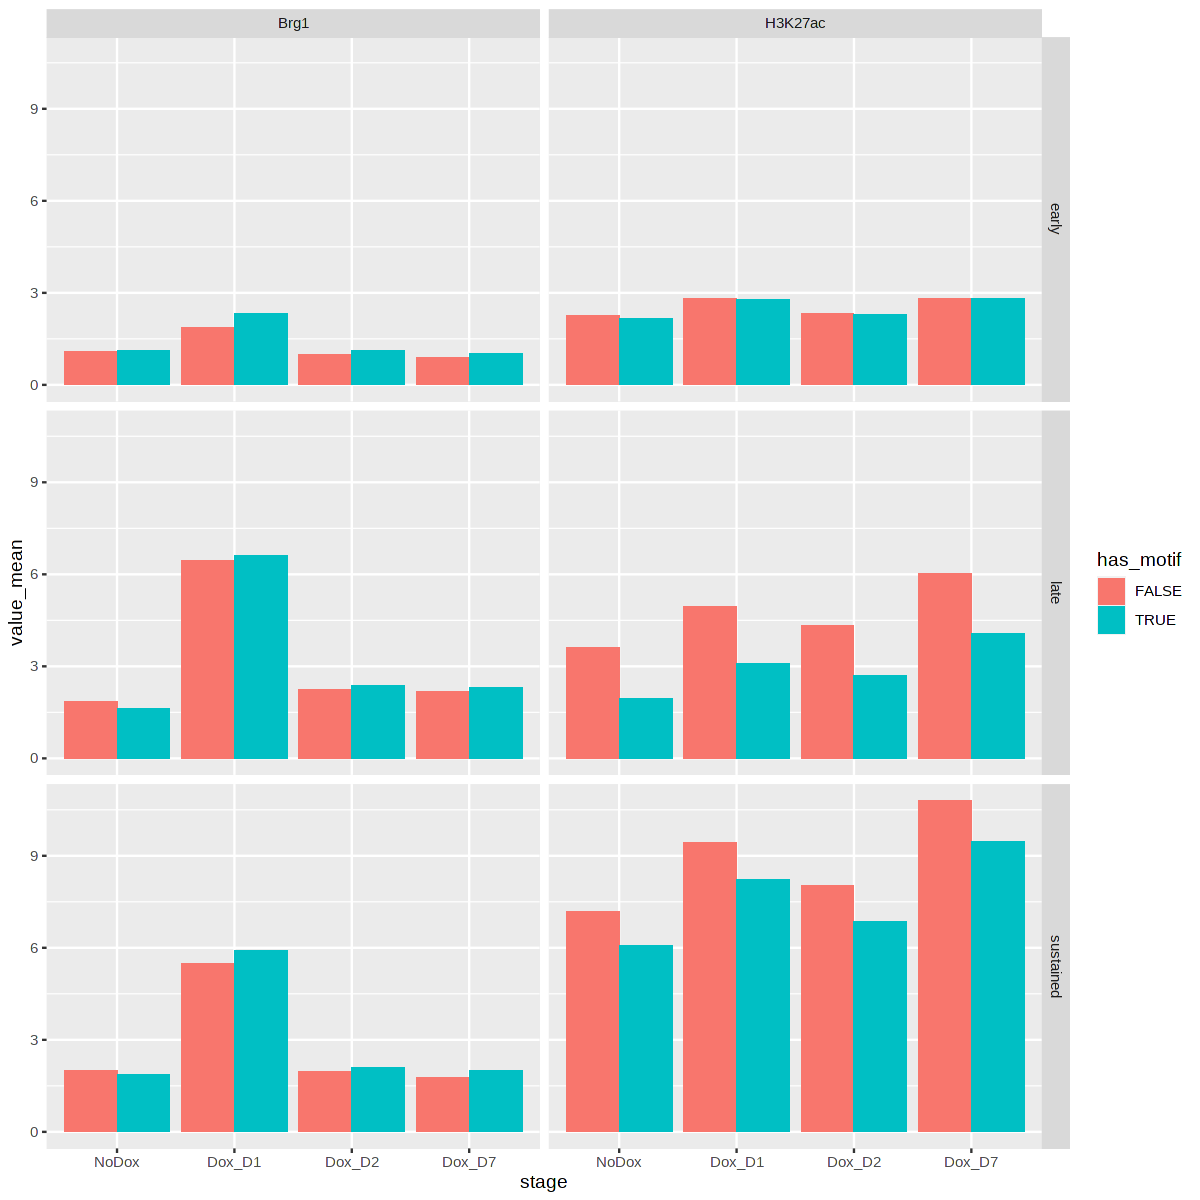

In [150]:
options(repr.plot.width = 10, repr.plot.height = 10)
d %>% 
  group_by(has_motif, type, group) %>%
  summarize(value_mean = mean(value)) %>%
  ungroup() %>%
  mutate(antibody = gsub('.+_(.+)', '\\1', type)) %>%
  mutate(stage = gsub('MEF_(.+)_(.+)', '\\1', type)) %>%
  mutate(stage = factor(stage, c('NoDox', 'Dox_D1', 'Dox_D2', 'Dox_D7'))) %>%
  ggplot(aes(x = stage, y = value_mean, fill = has_motif)) + 
      geom_bar(stat="identity", position=position_dodge()) +
      facet_grid(group ~ antibody)

It looks pretty clear that Brg1 intensity increased from MEF to D1, post Etv2 induction. This supports the notation that Etv2 binding recruits Brg1. This recruitment is particularly strong for `sustained` peaks.  In current Figure 3a, the reason that we did not see a strong increase of Brg1 intensity from MEF to D1 might be due to the scaling problems - we will probably need to use the same scaling for each heatmap.  The Etv2 peaks with caonical Etv2 motifs recruit more Brg1 than the peaks without motifs, suggesting that the `scanning` events are less likely to introduce Brg1 recruiting.

## Prepare normalized matrix for `EnrichedHeatmap`

In [157]:
sprintf('number of Etv2 peaks in MEFS: %d', length(peaks)) %>% message()
sprintf('number of Etv2 peaks with canonical Etv2 motifs in MEFS: %d', length(peaks[has_motif])) %>% message()

number of Etv2 peaks in MEFS: 127559

number of Etv2 peaks with canonical Etv2 motifs in MEFS: 21343



In [158]:
peaks <- peaks[has_motif]

In [159]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(peaks)[1]
message(sprintf('target width: %d\n', target_width))

# peaks: 21343
target width: 200


In [170]:
mat <- mclapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    peaks, 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
}, mc.cores = 2)

### Color scheme of the heatmap

In [174]:
group_cols <- rep('blue', length(bw_files))
names(group_cols) <- names(bw_files)
group_cols[c('H3', 'MNase')] <- 'green'
group_cols[c('MEF_Dox_D1_Etv2', 'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2')] <- 'red'
group_cols[c('MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1')] <- 'purple'
group_cols[c('MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac')] <- 'darkgreen'
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

### Generate the heatmap

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FA

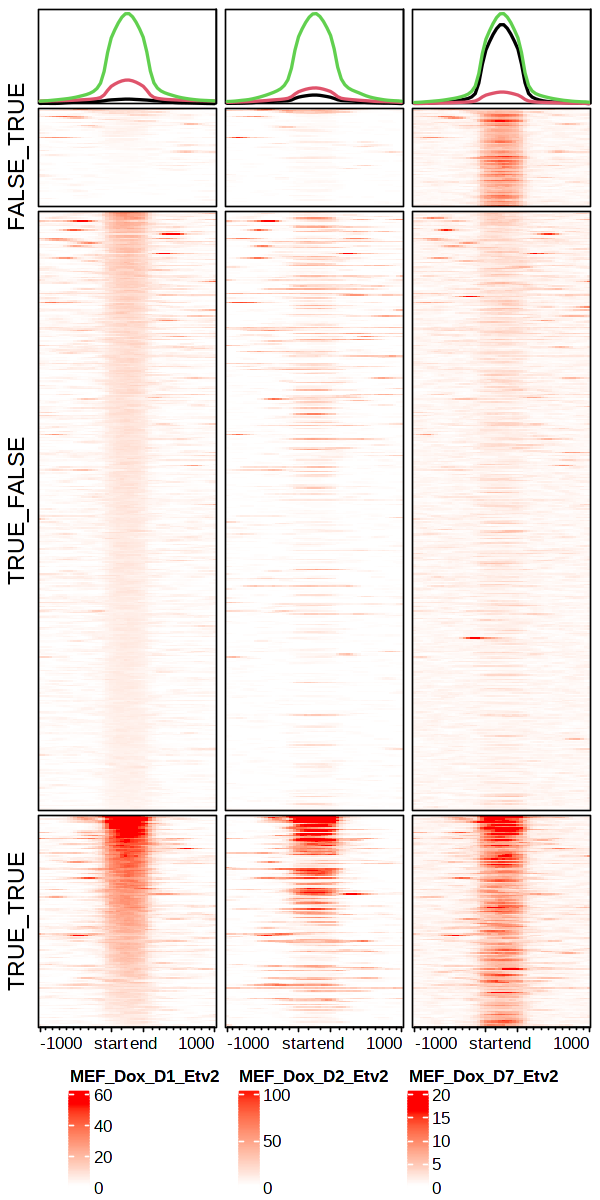

In [188]:
i <- 1:length(peaks)
sp <- factor(sprintf('%s_%s', peaks$group[, 'MEF_Dox_d1_Etv2'], peaks$group[, 'MEF_Dox_d7_Etv2']))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside', at = -1000)
#    ylim = c(0, 10)
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Dox_D1_Etv2']][i, ], 
  col = col_fun[['MEF_Dox_D1_Etv2']], 
  split = sp[i], 
  name = 'MEF_Dox_D1_Etv2', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2'
#  'MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1'
#  'MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 5, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FA

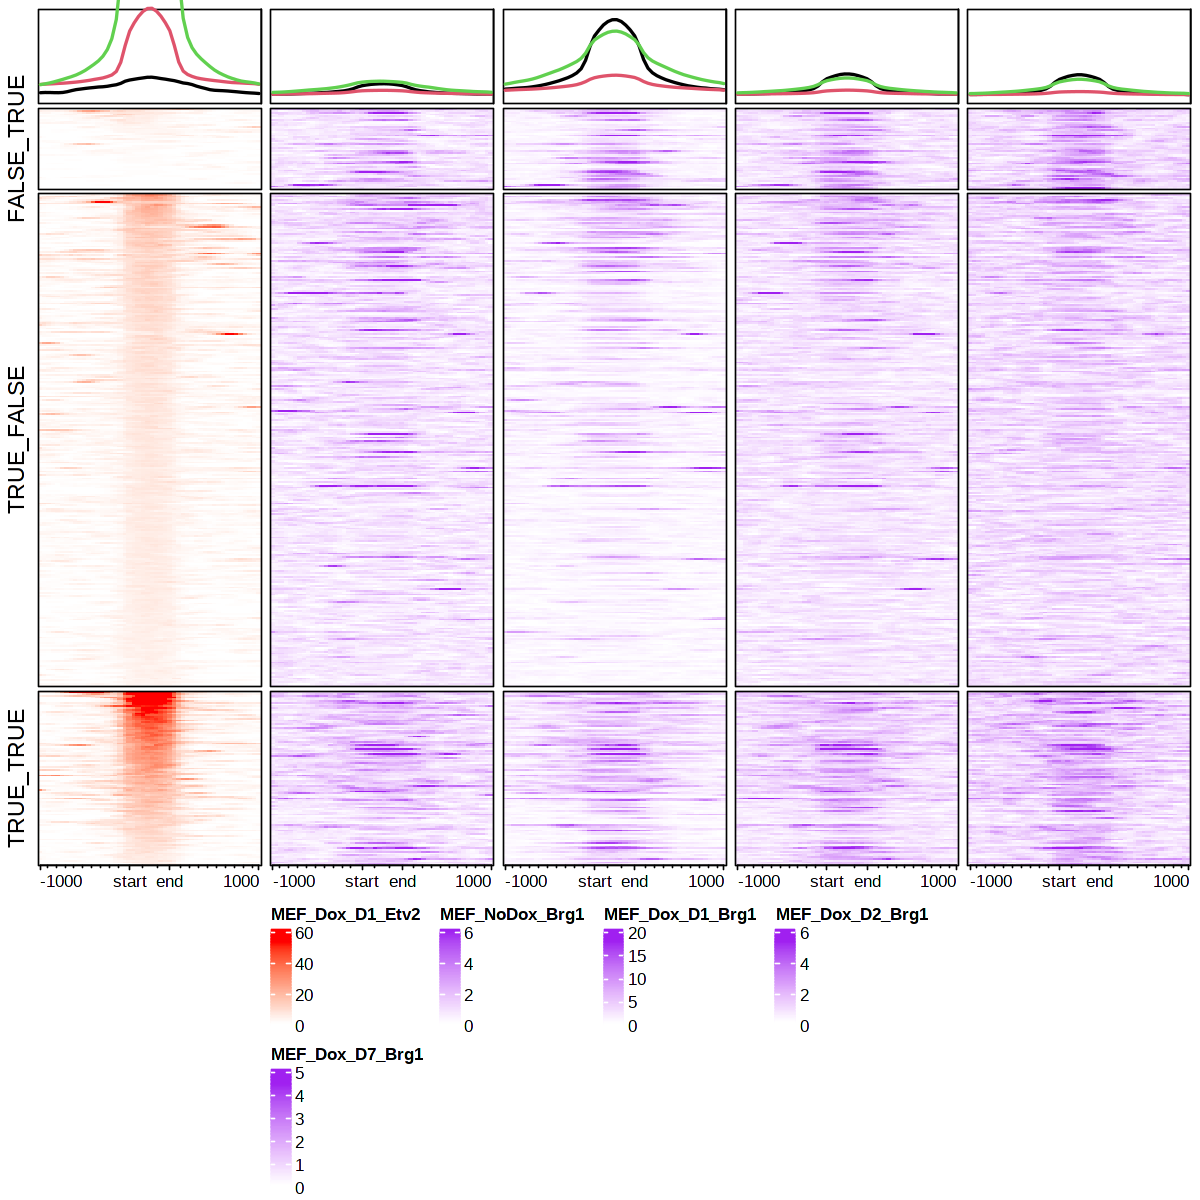

In [195]:
i <- 1:length(peaks)
sp <- factor(sprintf('%s_%s', peaks$group[, 'MEF_Dox_d1_Etv2'], peaks$group[, 'MEF_Dox_d7_Etv2']))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside', at = -1000),
    ylim = c(0, 8)
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Dox_D1_Etv2']][i, ], 
  col = col_fun[['MEF_Dox_D1_Etv2']], 
  split = sp[i], 
  name = 'MEF_Dox_D1_Etv2', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
#  'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2'
  'MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1'
#  'MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

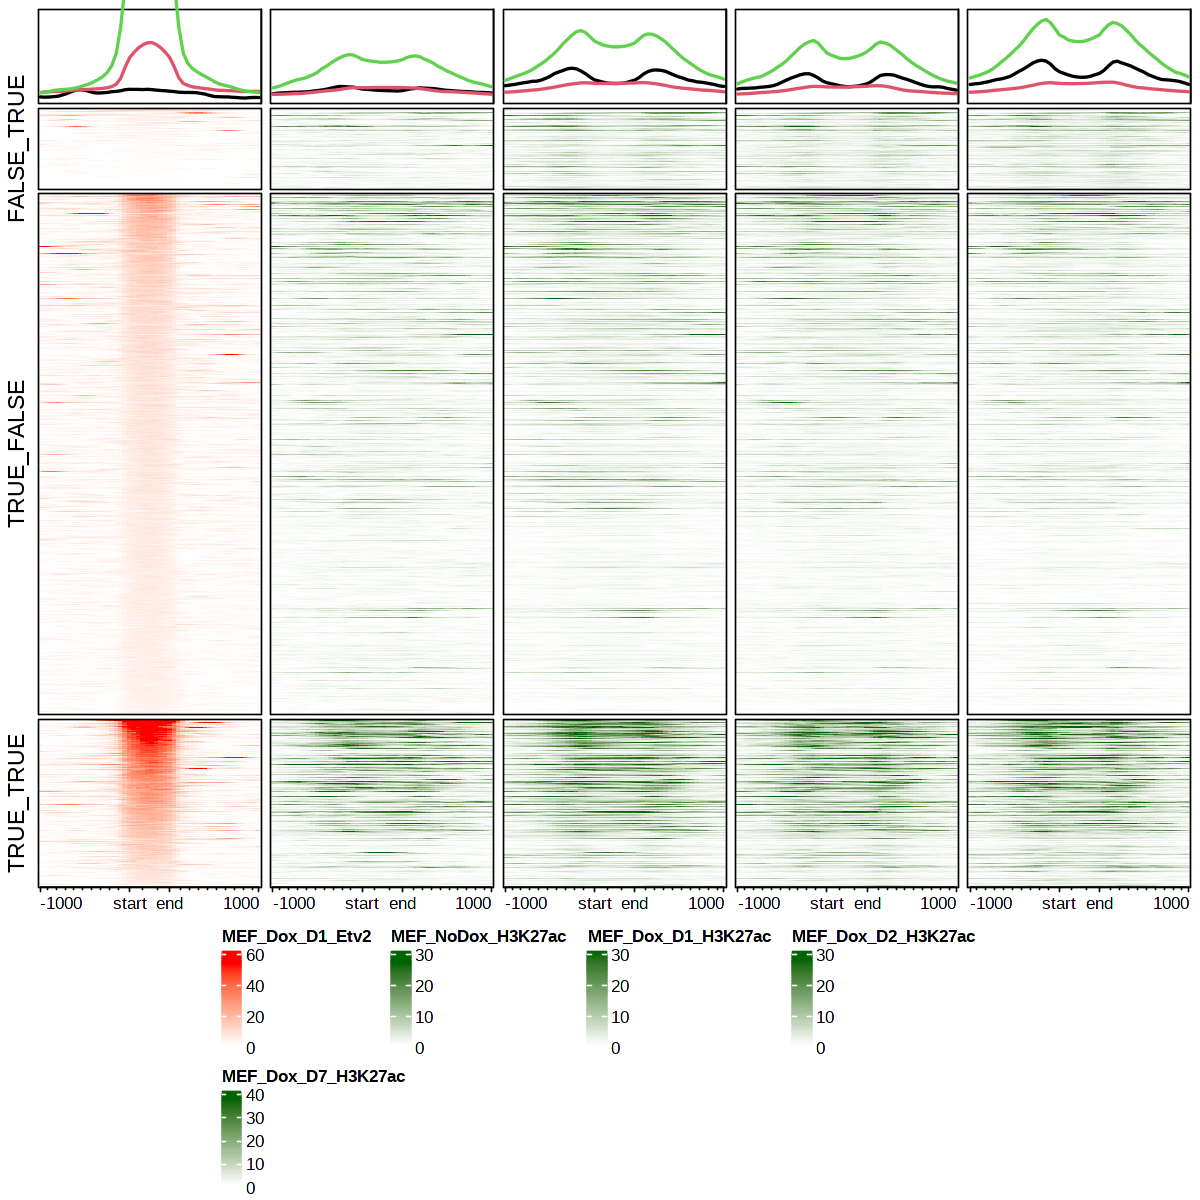

In [199]:
i <- sample(1:length(peaks), 2000)
sp <- factor(sprintf('%s_%s', peaks$group[, 'MEF_Dox_d1_Etv2'], peaks$group[, 'MEF_Dox_d7_Etv2']))
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside', at = -1000),
    ylim = c(0, 13)
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Dox_D1_Etv2']][i, ], 
  col = col_fun[['MEF_Dox_D1_Etv2']], 
  split = sp[i], 
  name = 'MEF_Dox_D1_Etv2', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
#  'MEF_Dox_D2_Etv2', 'MEF_Dox_D7_Etv2'
#  'MEF_NoDox_Brg1', 'MEF_Dox_D1_Brg1', 'MEF_Dox_D2_Brg1', 'MEF_Dox_D7_Brg1'
  'MEF_NoDox_H3K27ac', 'MEF_Dox_D1_H3K27ac', 'MEF_Dox_D2_H3K27ac', 'MEF_Dox_D7_H3K27ac'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

In [192]:
sprintf('# of early peaks: %d', sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & !peaks$group[, 'MEF_Dox_d7_Etv2'])) %>% message()
sprintf('# of sustained peaks: %d', sum(peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])) %>% message()
sprintf('# of early late: %d', sum(!peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2'])) %>% message()

# of early peaks: 14074

# of sustained peaks: 4965

# of early late: 2304



In [ ]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] EnrichedHeatmap_1.18.2                   
 [2] ComplexHeatmap_2.4.3                     
 [3] GO.db_3.11.4                             
 [4] org.Mm.eg.db_3.11.4                      
 [5] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0

In [ ]:
Sys.time() - start_time0

Time difference of 1.516958 hours